# Gemini Workshop: The Hands-On Lab Session


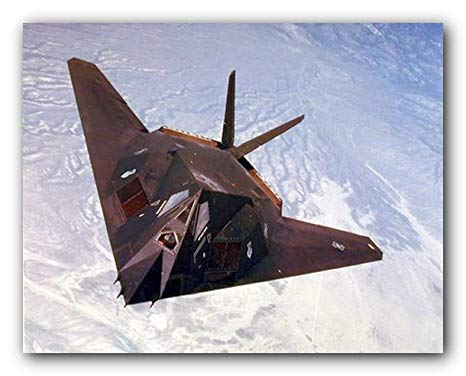

In [1]:
from IPython.display import Image
Image("asurprise.jpg") 


# Load The RF Signals With Known Type


In [2]:
import rf_signals
rf_signals.load()

Using radioml dataset directory at ../../../signal
Loading fingerprints...
Loading raw signals...
Loading signal labels...
Loading signal-to-noise values...
The RF signal database loaded successfully.  There are 100000 total signals.


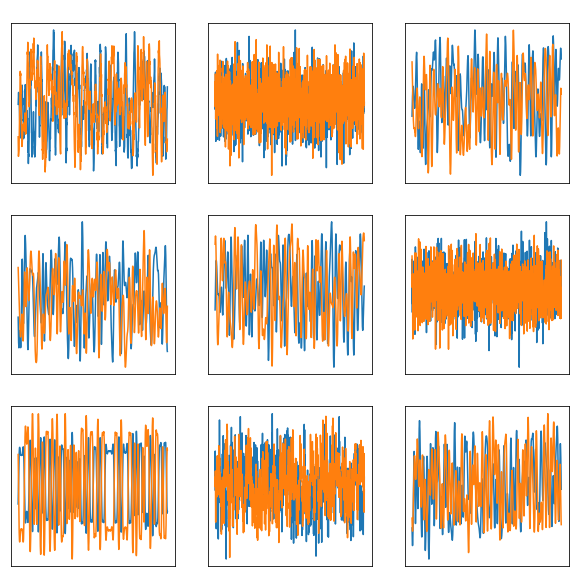

In [3]:
rf_signals.randisplay()


# Load The RF Signals Database With Unknown Type

In [4]:
import unknown_signals
unknown_signals.load()

Using rf signal dataset directory at ../../../signal
Loading fingerprints...
Loading raw signals...
Loading signal-to-noise values...
The RF signal database loaded successfully.  There are 50 total signals.


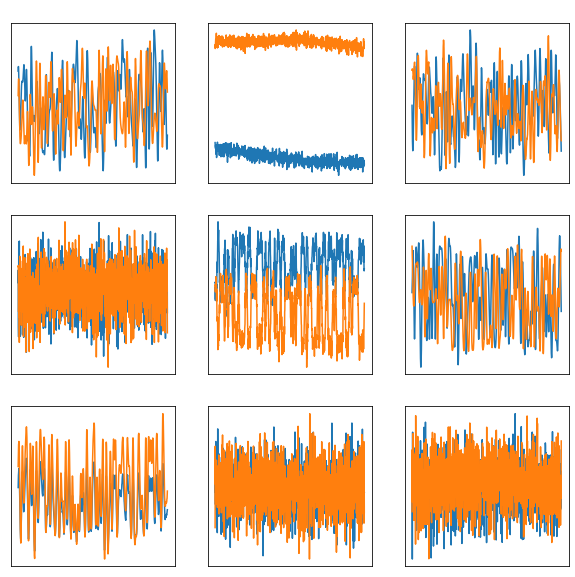

In [5]:
unknown_signals.randisplay()


# Here is a Picture of the Machine and Gemini Card We Will Be Using!

<img src="rack_machine.png">,



# Import The Known Signal Database Into Gemini



In [6]:
import swagger_client
from swagger_client.models import *
from swagger_client.rest import ApiException
import sys

# Configuration
configuration = swagger_client.configuration.Configuration()
configuration.verify_ssl = False
configuration.host = "http://localhost:7761/v1.0"
api_config = swagger_client.ApiClient(configuration)

# Get handls to various GSI library objects
gsi_boards_apis = swagger_client.BoardsApi(api_config)
gsi_datasets_apis = swagger_client.DatasetsApi(api_config)
gsi_search_apis = swagger_client.SearchApi(api_config)

# Set this to None or a valid dataset id 
dataset_id = "14f34d04-71a7-11eb-aa48-0242ac110002"

if not dataset_id:
    try:

        # Import Dataset
        print("OK, about to import the dataset. This may take a while...")
        response = gsi_datasets_apis.apis_import_dataset(body=ImportDatasetRequest(rf_signals.path, train_ind=True))
        dataset_id = response.dataset_id
        print("Import done!")

    except ApiException as e:
        print(e.status)
        print(e.body)
        print(e.reason)
        raise e
        
else:
    print("Using a dataset already loaded with dataset_id = ", dataset_id )

Using a dataset already loaded with dataset_id =  14f34d04-71a7-11eb-aa48-0242ac110002


# Load the Known Signal Vectors Into Gemini

In [7]:

try:

    print("Using dataset with dataset_id = ", dataset_id)  

    # Allocate Board/s
    num_of_boards = 1
    print("Allocating the %d board(s)..." % num_of_boards)
    response = gsi_boards_apis.apis_allocate(body=AllocateRequest(num_of_boards))
    allocation_id = response.allocation_id
    print("Allocation done!")

    # Load Dataset That Has Already Been Imported
    print("Loading the dataset into the APU")
    gsi_datasets_apis.apis_load_dataset(body=LoadDatasetRequest(allocation_id, dataset_id, topk=25))
    print("Load done!")


except ApiException as e:
    print(e.status)
    print(e.body)
    print(e.reason)
    raise e


Using dataset with dataset_id =  14f34d04-71a7-11eb-aa48-0242ac110002
Allocating the 1 board(s)...
Allocation done!
Loading the dataset into the APU
Load done!



# Perform the Vector Similarity Search On Gemini


In [9]:

try:

    # Search
    print("Performing the searching...")
    search_api_response = gsi_search_apis.apis_search(body=SearchRequest(allocation_id, dataset_id, 
                                                            queries_path=unknown_signals.path))
    indices = search_api_response.indices
    print("Search done!")

except ApiException as e:
    print(e.status)
    print(e.body)
    print(e.reason)
    raise e


Performing the searching...
Search done!


# Cleanup Unused Resources


In [10]:

# Deallocate Board/s
if allocation_id is not None:
    gsi_boards_apis.apis_deallocate(body=DeallocateRequest(allocation_id))
    allocation_id = None

# Unload Dataset
# gsi_datasets_apis.apis_unload_dataset(body=UnloadDatasetRequest(allocation_id, dataset_id))
    
print("Done.")

Done.



# Perform KNN Inference To Classify the Unknown Signals



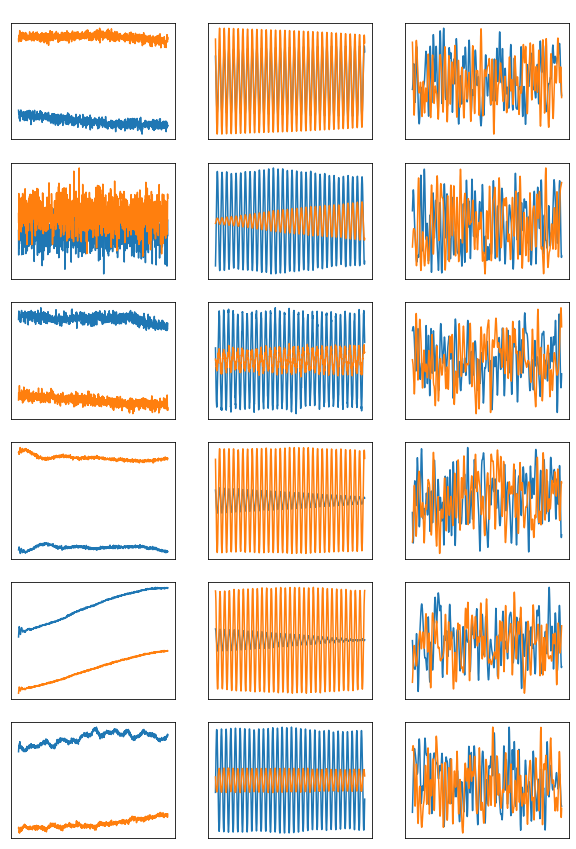

In [11]:
import knn
predictions = knn.classify( rf_signals, unknown_signals, indices, k=5 )
knn.randisplay( predictions, rf_signals, unknown_signals )